In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ta
from mplfinance.original_flavor import candlestick_ohlc
import matplotlib.dates as mdates

from finta import TA
from prophet import Prophet

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

import pickle

Importing plotly failed. Interactive plots will not work.


## Loading Data

In [2]:
df = pd.read_csv("data/nvidia.csv")
df2 = pd.read_csv("data/nvidia-labeled.csv")

In [3]:
df.rename(columns={'Unnamed: 0':'Date'}, inplace=True)

In [4]:
df2['Date'] = pd.to_datetime(df2['timestamp']).dt.strftime('%Y-%m-%d')
df2

,series,timestamp,value,label,Date
0,nvidia,2021-01-04T11:59:00.000Z,2619.11,long,2021-01-04
1,nvidia,2021-01-05T11:59:00.000Z,2661.75,long,2021-01-05
2,nvidia,2021-01-06T11:59:00.000Z,2485.63,long,2021-01-06
3,nvidia,2021-01-07T11:59:00.000Z,2676.98,long,2021-01-07
4,nvidia,2021-01-08T11:59:00.000Z,2645.37,long,2021-01-08
...,...,...,...,...,...
978,nvidia,2023-09-09T11:59:00.000Z,7941.49,short,2023-09-09
979,nvidia,2023-09-10T11:59:00.000Z,7881.26,short,2023-09-10
980,nvidia,2023-09-11T11:59:00.000Z,7821.04,short,2023-09-11
981,nvidia,2023-09-12T11:59:00.000Z,7744.23,short,2023-09-12


In [5]:
df = df.merge(df2[['Date', 'label']], on='Date', how='left')
df

,Date,Open,High,Low,Close,Adj Close,Volume,label
0,2021-01-04,2576.250000,2706.250000,2568.750000,2619.112549,2618.825928,6868.0,long
1,2021-01-05,2677.000000,2677.000000,2637.502441,2661.752441,2661.461182,892.0,long
2,2021-01-06,2666.250000,2666.250000,2477.750000,2485.632568,2485.360840,6124.0,long
3,2021-01-07,2500.002441,2677.500000,2500.002441,2676.982422,2676.690186,8140.0,long
4,2021-01-08,2638.000000,2663.000000,2624.500000,2645.372559,2645.083252,7868.0,long
...,...,...,...,...,...,...,...,...
978,2023-09-09,8075.006510,8101.660156,7902.346680,7941.486654,7941.486654,1922.0,short
979,2023-09-10,8060.003255,8073.330078,7823.673340,7881.263346,7881.263346,2391.0,short
980,2023-09-11,8045.000000,8045.000000,7745.000000,7821.040039,7821.040039,2860.0,short
981,2023-09-12,7785.000000,7918.000000,7735.000000,7744.229980,7744.229980,4798.0,short


## Feature Engineering

In [6]:
ts = df[['Date', 'Close']].rename(columns={'Date': 'ds', 'Close': 'y'})

In [7]:
m = Prophet()
m.fit(ts)
future = m.make_future_dataframe(periods=0)
forecast = m.predict(future)

15:35:34 - cmdstanpy - INFO - Chain [1] start processing
15:35:35 - cmdstanpy - INFO - Chain [1] done processing


In [8]:
season = forecast[['ds', 'trend', 'weekly', 'yearly']]
season.ds = season.ds.dt.strftime('%Y-%m-%d')

/home/gibran/.local/lib/python3.10/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


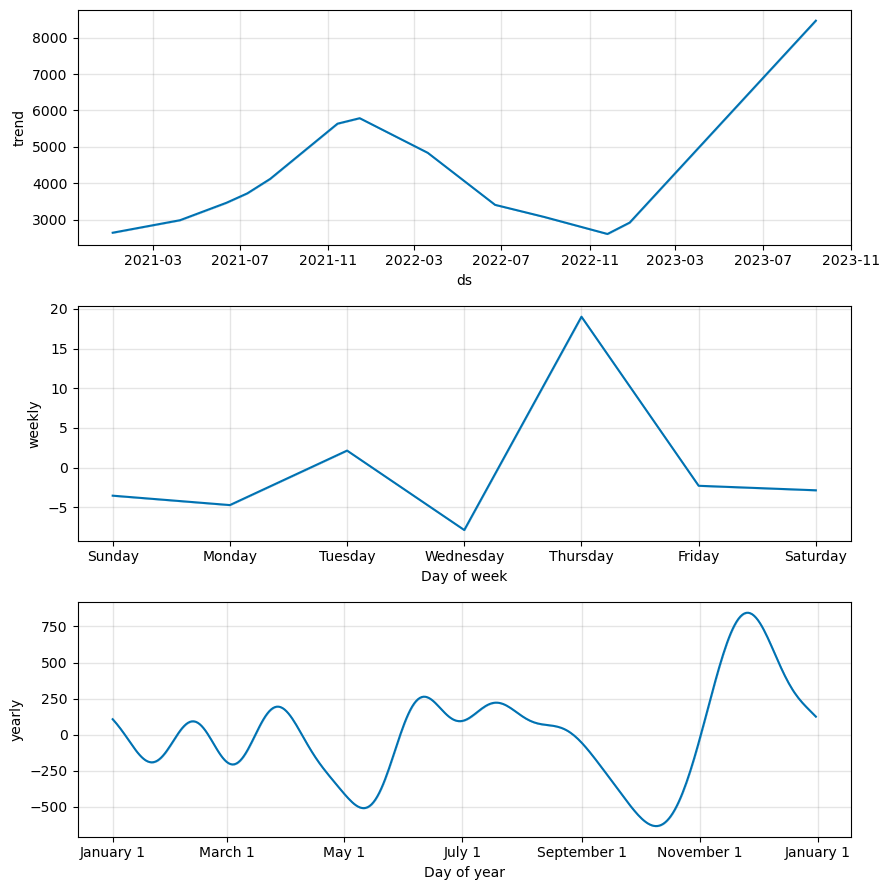

In [9]:
fig2 = m.plot_components(forecast)


In [10]:
df = df.merge(season, left_on='Date', right_on='ds', how='left')
df

,Date,Open,High,Low,Close,Adj Close,Volume,label,ds,trend,weekly,yearly
0,2021-01-04,2576.250000,2706.250000,2568.750000,2619.112549,2618.825928,6868.0,long,2021-01-04,2648.643808,-4.698774,58.941569
1,2021-01-05,2677.000000,2677.000000,2637.502441,2661.752441,2661.461182,892.0,long,2021-01-05,2652.286161,2.157369,41.531057
2,2021-01-06,2666.250000,2666.250000,2477.750000,2485.632568,2485.360840,6124.0,long,2021-01-06,2655.928513,-7.836591,23.430196
3,2021-01-07,2500.002441,2677.500000,2500.002441,2676.982422,2676.690186,8140.0,long,2021-01-07,2659.570865,19.001933,4.736940
4,2021-01-08,2638.000000,2663.000000,2624.500000,2645.372559,2645.083252,7868.0,long,2021-01-08,2663.213218,-2.270943,-14.408051
...,...,...,...,...,...,...,...,...,...,...,...,...
978,2023-09-09,8075.006510,8101.660156,7902.346680,7941.486654,7941.486654,1922.0,short,2023-09-09,8377.313839,-2.837994,-181.594076
979,2023-09-10,8060.003255,8073.330078,7823.673340,7881.263346,7881.263346,2391.0,short,2023-09-10,8398.607595,-3.515000,-199.116672
980,2023-09-11,8045.000000,8045.000000,7745.000000,7821.040039,7821.040039,2860.0,short,2023-09-11,8419.901352,-4.698774,-216.778130
981,2023-09-12,7785.000000,7918.000000,7735.000000,7744.229980,7744.229980,4798.0,short,2023-09-12,8441.195109,2.157369,-234.548155


In [11]:
df.to_csv("data/nvidia_season.csv", index=False)

In [12]:
def linreg(y):
    x = np.arange(len(y))
    coef = np.polyfit(x,y,1)
    return coef[0]

df['SMA24'] = TA.SMA(df, 24)
df['SMA12'] = TA.SMA(df, 12)
df['SMA9'] = TA.SMA(df, 9)
df['SMA6'] = TA.SMA(df, 6)
df['SMA3'] = TA.SMA(df, 3)
df['slope'] = df['Close'].rolling(3).apply(linreg).fillna(0)
#df['RSI'] = TA.RSI(df)
#df['OBV'] = TA.OBV(df)
#df['PIVOT_FIB'] = TA.PIVOT_FIB(df)
#df['BBANDS'] = TA.BBANDS(df)



df['MFI'] = TA.MFI(df)
df[['BASP_BUY', 'BASP_SELL']] = TA.BASP(df)

#df['FISH'] = TA.FISH(df)

df = df[23:]
df.reset_index(drop=True, inplace=True)
df.fillna(0, inplace=True)


/home/gibran/.local/lib/python3.10/site-packages/pandas/core/frame.py:5176: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [13]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,label,ds,trend,...,yearly,SMA24,SMA12,SMA9,SMA6,SMA3,slope,MFI,BASP_BUY,BASP_SELL
0,2021-01-27,2652.000000,2652.000000,2600.000000,2610.292480,2610.007324,9772.0,long,2021-01-27,2732.417911,...,-146.771077,2645.449595,2647.832499,2686.276666,2708.307495,2677.125000,-64.088745,47.886072,0.393676,0.991939
1,2021-01-28,2658.625000,2678.587402,2637.500000,2638.800049,2638.511230,1716.0,long,2021-01-28,2736.060263,...,-130.611358,2646.269908,2656.065837,2694.720839,2691.440837,2643.901693,-21.906250,50.380581,0.009883,0.177886
2,2021-01-29,2625.000000,2677.500000,2603.692383,2674.367432,2674.075195,5384.0,long,2021-01-29,2739.702615,...,-112.675835,2646.795532,2667.888123,2700.206109,2680.587077,2641.153320,32.037476,56.275514,1.564205,0.047947
3,2021-01-30,2650.703125,2690.818115,2626.519287,2688.296204,2688.002319,6015.0,long,2021-01-30,2743.344968,...,-93.330793,2655.239850,2681.496140,2694.589851,2672.139781,2667.154561,24.748077,56.496273,1.455704,0.046709
4,2021-01-31,2676.406250,2704.136230,2649.346191,2702.224976,2701.929443,6646.0,long,2021-01-31,2746.987320,...,-72.980886,2656.291623,2693.114680,2690.392626,2666.098948,2688.296204,13.928772,57.916784,1.337078,0.042079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2023-09-09,8075.006510,8101.660156,7902.346680,7941.486654,7941.486654,1922.0,short,2023-09-09,8377.313839,...,-181.594076,7992.642775,8243.758002,8232.991735,8193.511041,8021.822211,-90.391683,52.460890,0.018770,0.086496
956,2023-09-10,8060.003255,8073.330078,7823.673340,7881.263346,7881.263346,2391.0,short,2023-09-10,8398.607595,...,-199.116672,8012.561666,8220.486613,8187.695475,8114.054932,7941.486654,-60.223307,56.824836,0.036976,0.130806
957,2023-09-11,8045.000000,8045.000000,7745.000000,7821.040039,7821.040039,2860.0,short,2023-09-11,8419.901352,...,-216.778130,8030.105408,8185.750773,8133.149577,8001.353271,7881.263346,-60.223307,64.272703,0.062291,0.182910
958,2023-09-12,7785.000000,7918.000000,7735.000000,7744.229980,7744.229980,4798.0,short,2023-09-12,8441.195109,...,-234.548155,8036.300401,8128.621582,8067.511068,7918.666667,7815.511122,-68.516683,59.485487,0.013845,0.243325


In [14]:

df.label.value_counts()

long     586
short    374
Name: label, dtype: int64

In [15]:
cols = ['Volume','SMA24', 'SMA12', 'SMA9', 'SMA6', 'SMA3',  'slope', 'MFI', 'BASP_BUY', 'BASP_SELL', 'trend', 'weekly', 'yearly']
#cols = ['Volume','SMA24', 'SMA12', 'SMA9', 'SMA6', 'SMA3',  'trend']

In [16]:
X = df[cols].values
y = df['label'].values

In [17]:
X.shape

(960, 13)

# Model Training

In [18]:
#train_arrays, test_arrays, train_labels, test_labels = train_test_split(X,y,test_size=0.1)
n = 870
train_arrays, test_arrays, train_labels, test_labels = X[:n], X[n:], y[:n], y[n:]

In [19]:
scaler = StandardScaler()
train_arrays = scaler.fit_transform(train_arrays)

In [20]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10, 50, 100,200,1000]
    #Cs = [1.070, 1.074, 1.075, 1.1, 1.125]
    gammas = [0.0001,0.001, 0.005, 0.01, 0.1, 1]
    #gammas = [2.065,2.075, 2.08]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel='rbf'), param_grid, cv=nfolds, n_jobs=8)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search

In [21]:
# model = svc_param_selection(train_arrays,train_labels, 5)
# model.best_params_

In [22]:
model = SVC(kernel='rbf')
model.fit(train_arrays, train_labels)

SVC()

In [23]:
pred = model.predict(scaler.transform(test_arrays))

In [24]:
cm = confusion_matrix(test_labels,pred)
cm

array([[32, 29],
       [15, 14]])

In [25]:
accuracy = accuracy_score(train_labels, model.predict(train_arrays))
accuracy

0.8839080459770114

In [26]:
accuracy = accuracy_score(test_labels,pred)
accuracy

0.5111111111111111

In [27]:
pred

array(['short', 'short', 'short', 'short', 'long', 'long', 'short',
       'short', 'short', 'short', 'short', 'short', 'short', 'short',
       'short', 'short', 'short', 'short', 'short', 'short', 'long',
       'short', 'short', 'short', 'short', 'short', 'long', 'long',
       'long', 'short', 'long', 'long', 'long', 'short', 'short', 'short',
       'short', 'short', 'short', 'long', 'long', 'long', 'long', 'short',
       'short', 'short', 'long', 'short', 'long', 'long', 'short', 'long',
       'long', 'short', 'short', 'short', 'short', 'short', 'long',
       'long', 'long', 'long', 'long', 'short', 'long', 'long', 'long',
       'long', 'long', 'long', 'short', 'short', 'long', 'long', 'long',
       'long', 'long', 'long', 'long', 'long', 'long', 'long', 'long',
       'long', 'long', 'long', 'long', 'long', 'long', 'long'],
      dtype=object)

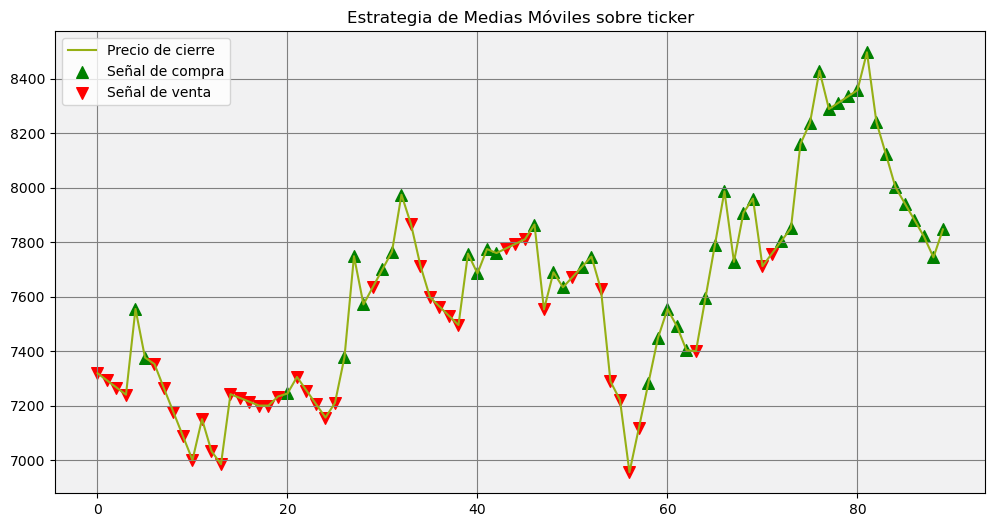

In [28]:
# Graficar cierre con la mejor combinación de medias móviles
plt.figure(figsize=(12, 6))
plt.plot(df['Close'].values[n:], label='Precio de cierre', color='#96B015')
plt.scatter(np.where(pred == 'long'), df['Close'].values[n:][np.where(pred == 'long')],
            color='g',
            marker='^',
            s=70,
            label='Señal de compra')
plt.scatter(np.where(pred == 'short'), df['Close'].values[n:][np.where(pred == 'short')],
            color='red',
            marker='v',
            s=70,
            label='Señal de venta')
plt.legend()
plt.title('Estrategia de Medias Móviles sobre ticker')
# Agregar grid
plt.grid(color='gray')
# Agregar fondo
plt.gca().set_facecolor('#F1F1F2')
plt.show()

In [30]:
filename = 'models/nvidia_model.sav'
pickle.dump(model, open(filename, 'wb'))

## Backtesting

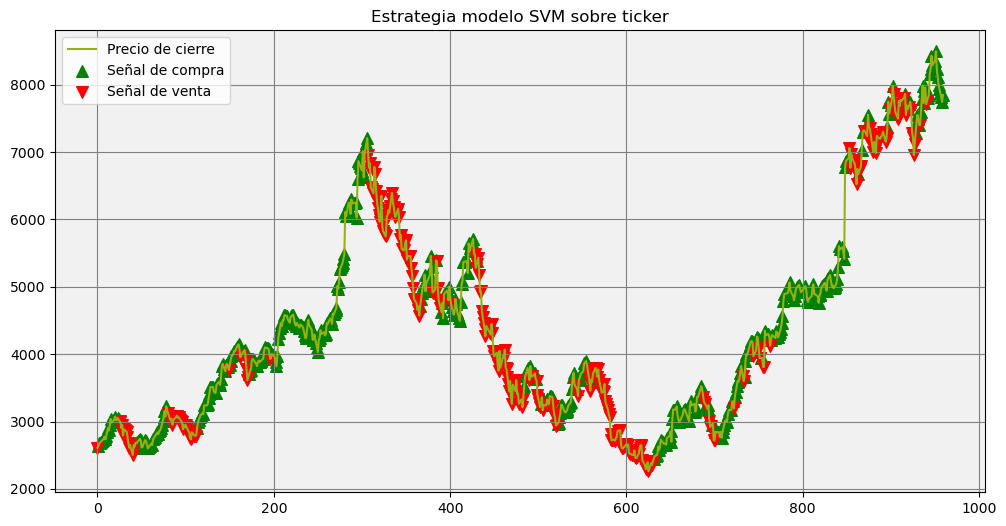

In [31]:
pred = model.predict(scaler.transform(X))
plt.figure(figsize=(12, 6))
plt.plot(df['Close'].values, label='Precio de cierre', color='#96B015')
plt.scatter(np.where(pred == 'long'), df['Close'].values[np.where(pred == 'long')],
            color='g',
            marker='^',
            s=70,
            label='Señal de compra')
plt.scatter(np.where(pred == 'short'), df['Close'].values[np.where(pred == 'short')],
            color='red',
            marker='v',
            s=70,
            label='Señal de venta')
plt.legend()
plt.title('Estrategia modelo SVM sobre ticker')
# Agregar grid
plt.grid(color='gray')
# Agregar fondo
plt.gca().set_facecolor('#F1F1F2')
plt.show()

In [32]:
df

,Date,Open,High,Low,Close,Adj Close,Volume,label,ds,trend,...,yearly,SMA24,SMA12,SMA9,SMA6,SMA3,slope,MFI,BASP_BUY,BASP_SELL
0,2021-01-27,2652.000000,2652.000000,2600.000000,2610.292480,2610.007324,9772.0,long,2021-01-27,2732.417911,...,-146.771077,2645.449595,2647.832499,2686.276666,2708.307495,2677.125000,-64.088745,47.886072,0.393676,0.991939
1,2021-01-28,2658.625000,2678.587402,2637.500000,2638.800049,2638.511230,1716.0,long,2021-01-28,2736.060263,...,-130.611358,2646.269908,2656.065837,2694.720839,2691.440837,2643.901693,-21.906250,50.380581,0.009883,0.177886
2,2021-01-29,2625.000000,2677.500000,2603.692383,2674.367432,2674.075195,5384.0,long,2021-01-29,2739.702615,...,-112.675835,2646.795532,2667.888123,2700.206109,2680.587077,2641.153320,32.037476,56.275514,1.564205,0.047947
3,2021-01-30,2650.703125,2690.818115,2626.519287,2688.296204,2688.002319,6015.0,long,2021-01-30,2743.344968,...,-93.330793,2655.239850,2681.496140,2694.589851,2672.139781,2667.154561,24.748077,56.496273,1.455704,0.046709
4,2021-01-31,2676.406250,2704.136230,2649.346191,2702.224976,2701.929443,6646.0,long,2021-01-31,2746.987320,...,-72.980886,2656.291623,2693.114680,2690.392626,2666.098948,2688.296204,13.928772,57.916784,1.337078,0.042079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,2023-09-09,8075.006510,8101.660156,7902.346680,7941.486654,7941.486654,1922.0,short,2023-09-09,8377.313839,...,-181.594076,7992.642775,8243.758002,8232.991735,8193.511041,8021.822211,-90.391683,52.460890,0.018770,0.086496
956,2023-09-10,8060.003255,8073.330078,7823.673340,7881.263346,7881.263346,2391.0,short,2023-09-10,8398.607595,...,-199.116672,8012.561666,8220.486613,8187.695475,8114.054932,7941.486654,-60.223307,56.824836,0.036976,0.130806
957,2023-09-11,8045.000000,8045.000000,7745.000000,7821.040039,7821.040039,2860.0,short,2023-09-11,8419.901352,...,-216.778130,8030.105408,8185.750773,8133.149577,8001.353271,7881.263346,-60.223307,64.272703,0.062291,0.182910
958,2023-09-12,7785.000000,7918.000000,7735.000000,7744.229980,7744.229980,4798.0,short,2023-09-12,8441.195109,...,-234.548155,8036.300401,8128.621582,8067.511068,7918.666667,7815.511122,-68.516683,59.485487,0.013845,0.243325


In [33]:
# Aplicar la estrategia all-in de backtesting 
capital_inicial = 10000 
positions = pred


portfolio = pd.Series(index=df.Date)
total_quantity = 0
wallet = capital_inicial

for i in range(0, df.shape[0]):
    
    position = positions[i]
    portfolio_change = 0
    
    curr_price = df['Close'][i]
    max_quantity = int(wallet/curr_price)
    
    if (position == 'long') & (max_quantity > 0):  # Señal de compra
        total_quantity += max_quantity
        wallet -= max_quantity * curr_price
    elif (position == 'short') & (total_quantity > 0):  # Señal de venta
        wallet += total_quantity * curr_price
        total_quantity = 0
    
    # Actualizar el valor del portfolio para el día actual
    portfolio[i] = wallet + total_quantity * curr_price
    print(i, position ,"price:", curr_price, 'protfolio:', portfolio[i], 'quantity:', total_quantity)

0 short price: 2610.29248046875 protfolio: 10000.0 quantity: 0
1 long price: 2638.800048828125 protfolio: 10000.0 quantity: 3
2 long price: 2674.367431640625 protfolio: 10106.7021484375 quantity: 3
3 long price: 2688.296203613281 protfolio: 10148.488464355467 quantity: 3
4 long price: 2702.224975585937 protfolio: 10190.274780273436 quantity: 3
5 long price: 2716.1537475585938 protfolio: 10232.061096191406 quantity: 3
6 long price: 2730.08251953125 protfolio: 10273.847412109375 quantity: 3
7 long price: 2737.5 protfolio: 10296.099853515625 quantity: 3
8 long price: 2774.550048828125 protfolio: 10407.25 quantity: 3
9 long price: 2734.324951171875 protfolio: 10286.57470703125 quantity: 3
10 long price: 2791.404134114583 protfolio: 10457.812255859375 quantity: 3
11 long price: 2848.4833170572915 protfolio: 10629.0498046875 quantity: 3
12 long price: 2905.5625 protfolio: 10800.287353515625 quantity: 3
13 long price: 2867.405029296875 protfolio: 10685.81494140625 quantity: 3
14 long price: 2

/tmp/ipykernel_1393900/1453743051.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  portfolio = pd.Series(index=df.Date)


In [34]:
portfolio

Date
2021-01-27     10000.000000
2021-01-28     10000.000000
2021-01-29     10106.702148
2021-01-30     10148.488464
2021-01-31     10190.274780
                  ...      
2023-09-09    122064.892741
2023-09-10    121161.543132
2023-09-11    120258.193522
2023-09-12    119106.042643
2023-09-13    120647.592936
Length: 960, dtype: float64

Sharpe Ratio: 2.3293981974771274


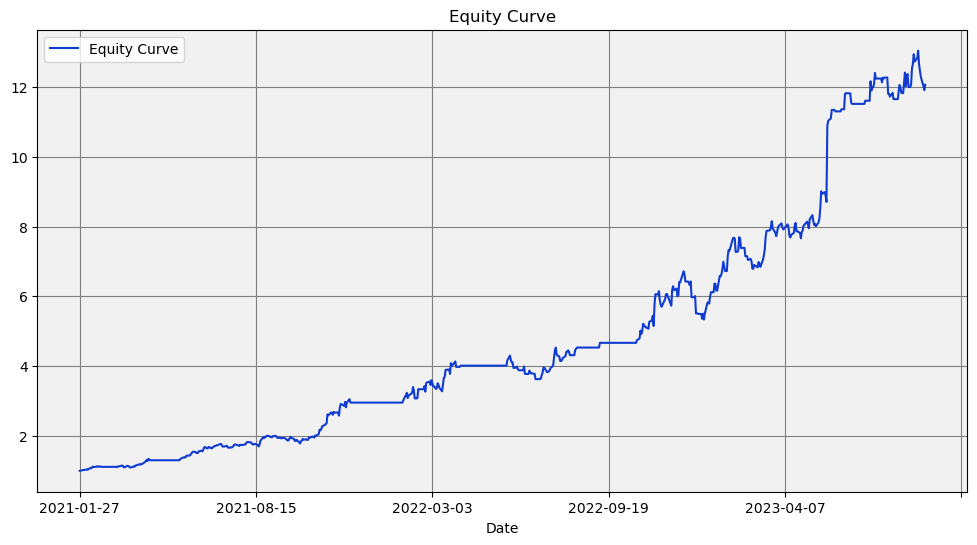

In [35]:
# Graficar el equity curve
equity_curve = portfolio / capital_inicial
equity_curve.plot(label='Equity Curve', figsize=(12, 6), color='#0F3BD1')
plt.legend()
plt.title('Equity Curve')
# Agregar grid
plt.grid(color='gray')
# Agregar fondo
plt.gca().set_facecolor('#F1F1F2')

# Calcular los rendimientos diarios y el Sharpe Ratio
daily_returns = equity_curve.pct_change()
sharpe_ratio = np.sqrt(252) * (daily_returns.mean() / daily_returns.std())

# Imprimir el Sharpe Ratio
print("Sharpe Ratio:", sharpe_ratio)